# Inception v3 Download

In [4]:
%matplotlib inline
import urllib.request
import tarfile
import zipfile
import os
import sys

In [5]:
def download_progress(count, block_size, total_size):
    percent = count * block_size * 100 // total_size
    sys.stdout.write("\rDownloading: {}%".format(percent))
    sys.stdout.flush()

In [6]:
url = 'http://download.tensorflow.org/models/image/imagenet/inception-2015-12-05.tgz'
filename = url.split('/')[-1]

download_dir = 'model/inception/'
file_path = os.path.join(download_dir, filename)

In [7]:
if not os.path.exists(file_path):
    if not os.path.exists(download_dir):
        os.makedirs(download_dir)
    
    print("Downloading", filename, "...")
    file_path, _ = urllib.request.urlretrieve(url=url,
                                              filename=file_path,
                                              reporthook=download_progress)
    print("Done.")
    
    print("Extracting files.")
    if file_path.endswith(".zip"):
        zipfile.ZipFile(file=file_path, mode="r").extractall(download_dir)
    elif file_path.endswith((".tar.gz", ".tgz")):
        tarfile.open(name=file_path, mode="r:gz").extractall(download_dir)
    os.remove(file_path)
    print("Done.")

In [8]:
if os.path.exists(file_path):
    print("Data has apparently already been downloaded and unpacked.")

Data has apparently already been downloaded and unpacked.


# CIFAR10 Download

In [86]:
import tensorflow as tf
cifar10 = tf.keras.datasets.cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [87]:
cls_names = ['airplane', 
             'automobile', 
             'bird', 
             'cat', 
             'deer', 
             'dog', 
             'frog', 
             'horse', 
             'ship', 
             'truck']

In [88]:
print(type(x_train))
print(type(y_train))
print(type(x_test))
print(type(y_test))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [89]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [90]:
print(x_train.dtype)
print(y_train.dtype)
print(x_test.dtype)
print(y_test.dtype)

uint8
uint8
uint8
uint8


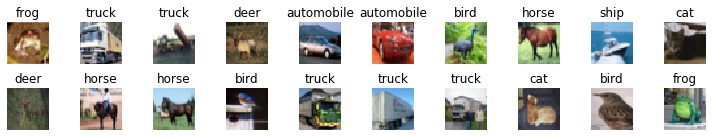

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(10,2))
for i in range(2):
    for j in range(10):
        axes[i, j].imshow(x_train[i*10+j], cmap=plt.cm.gray) 
        axes[i, j].set_title('{}'.format(cls_names[y_train[i*10+j, 0]]))
        axes[i, j].axis('off')
plt.tight_layout()
plt.show()

In [15]:
# data loading for transfer learning
import tensorflow as tf
import numpy as np
import copy
cifar10 = tf.keras.datasets.cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
# Inception needs pixels to be between 0 and 255
# x_train, x_test = x_train / 255. , x_test / 255.
x_train, x_test = x_train.astype(np.float32), x_test.astype(np.float32)
y_train, y_test = y_train.reshape((-1,)), y_test.reshape((-1,))
y_train_cls = copy.copy(y_train).astype(np.int32) 
y_test_cls = copy.copy(y_test).astype(np.int32)
y_train = np.eye(10)[y_train].astype(np.float32)
y_test = np.eye(10)[y_test].astype(np.float32)
print(y_test_cls[0], y_test[0])

3 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


# Restore Graph

In [16]:
import tensorflow as tf
tf.reset_default_graph()

In [17]:
tensor_name_input_jpeg = "DecodeJpeg/contents:0"
tensor_name_input_image = "DecodeJpeg:0"
tensor_name_resized_image = "ResizeBilinear:0"
tensor_name_softmax = "softmax:0"
tensor_name_softmax_logits = "softmax/logits:0"
tensor_name_transfer_layer = "pool_3:0"

In [18]:
graph = tf.Graph()
with graph.as_default():    
    data_dir = "model/inception/"
    path_graph_def = "classify_image_graph_def.pb"
    path = os.path.join(data_dir, path_graph_def)
    with tf.gfile.FastGFile(path, 'rb') as file:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(file.read())
        tf.import_graph_def(graph_def, name='')

Instructions for updating:
Use tf.gfile.GFile.


In [19]:
y_pred = graph.get_tensor_by_name(tensor_name_softmax)
y_logits = graph.get_tensor_by_name(tensor_name_softmax_logits)
resized_image = graph.get_tensor_by_name(tensor_name_resized_image)
transfer_layer = graph.get_tensor_by_name(tensor_name_transfer_layer)
transfer_len = transfer_layer.get_shape()[3]

In [20]:
sess = tf.Session(graph=graph)

# Compute Transfer-Values   

In [21]:
cache_path_train = os.path.join('data/CIFAR10', 'inception_cifar10_train.pkl')
cache_path_test = os.path.join('data/CIFAR10', 'inception_cifar10_test.pkl')

In [22]:
def compute_transfer_value(image):
    feed_dict = {tensor_name_input_image: image}
    transfer_value = sess.run(transfer_layer, feed_dict=feed_dict)
    return np.squeeze(transfer_value)

In [23]:
def process_images(f, images):
    num_images = images.shape[0]
    result = [None] * num_images
    for i in range(num_images):
        if (i+1)%100==0:
            msg = "Processing image: {:>6} / {}\n".format(i+1, num_images)
            sys.stdout.write(msg)
            sys.stdout.flush()
        result[i] = f(images[i])
    return np.array(result)

In [29]:
import pickle
if not os.path.exists(cache_path_train):
    t_train = process_images(compute_transfer_value, x_train)
    with open(cache_path_train, mode='wb') as file:
        pickle.dump(t_train, file)
else:
    with open(cache_path_train, mode='rb') as file:
        t_train = pickle.load(file)
    print('Data loaded from cache-file: {}'.format(cache_path_train))

Data loaded from cache-file: data/CIFAR10/inception_cifar10_train.pkl


In [30]:
import pickle
if not os.path.exists(cache_path_test):
    t_test = process_images(compute_transfer_value, x_test)
    with open(cache_path_test, mode='wb') as file:
        pickle.dump(t_test, file)
else:    
    with open(cache_path_test, mode='rb') as file:
        t_test = pickle.load(file)
    print('Data loaded from cache-file: {}'.format(cache_path_test))

Data loaded from cache-file: data/CIFAR10/inception_cifar10_test.pkl


In [31]:
print(t_train.shape, t_test.shape)
print(np.min(t_train), np.min(t_test))
print(np.max(t_train), np.max(t_test))

(50000, 2048) (10000, 2048)
0.0 0.0
9.71133 8.745262


# PCA

In [61]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

In [91]:
t_values = t_train[0:3000]
cls = y_train_cls[0:3000].reshape((-1,))
print(cls.shape)

(3000,)


In [80]:
t_values_reduced = pca.fit_transform(t_values)
print(t_values_reduced.shape)

(3000, 2)


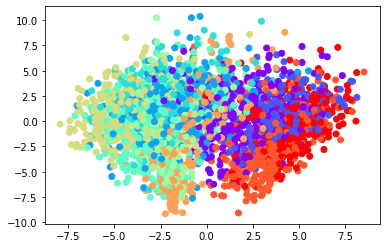

In [92]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
cmap = cm.rainbow(np.linspace(0.0, 1.0, 10))
color = cmap[cls]
x = t_values_reduced[:,0]
y = t_values_reduced[:,1]
plt.scatter(x, y, color=color)
plt.show()

# t-SNE

In [93]:
from sklearn.decomposition import PCA
pca = PCA(n_components=50)
t_values_50d = pca.fit_transform(t_values)

In [94]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)

In [96]:
t_values_reduced = tsne.fit_transform(t_values_50d) 

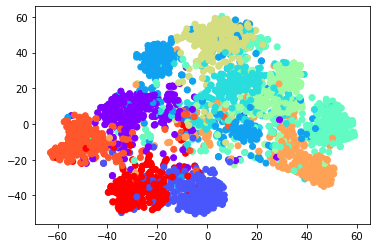

In [97]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
cmap = cm.rainbow(np.linspace(0.0, 1.0, 10))
color = cmap[cls]
x = t_values_reduced[:,0]
y = t_values_reduced[:,1]
plt.scatter(x, y, color=color)
plt.show()

# Transfer Learning

In [1]:
import tensorflow as tf
import numpy as np
tf.reset_default_graph()
tf.set_random_seed(0)
np.random.seed(0)

In [2]:
lr = 1e-2
epoch = int(1e3)
batch_size = 100

In [28]:
x = tf.placeholder(tf.float32, (None,2048)) 
y = tf.placeholder(tf.float32, (None,10)) 
y_cls = tf.placeholder(tf.int32, (None,)) 

b = tf.get_variable('b', (10,), tf.float32, tf.keras.initializers.constant(0.0))
w = tf.get_variable('w', (2048,10), tf.float32, tf.keras.initializers.he_normal())

logits = x @ w + b 
entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits=logits) 
loss = tf.reduce_mean(entropy) 
train = tf.train.GradientDescentOptimizer(learning_rate=lr).minimize(loss)

y_pred_cls = tf.cast(tf.argmax(logits, axis=1), tf.int32, name='y_pred_cls') 
correct_bool = tf.equal(y_pred_cls, y_cls, name='correct_bool') 
accuracy = tf.reduce_mean(tf.cast(correct_bool, tf.float32), name='accuracy') 

(?, 10) (?,) ()
(?,) (?,) ()
<dtype: 'int32'> <dtype: 'bool'> <dtype: 'float32'>


In [32]:
with tf.Session() as sess:
    
    tf.global_variables_initializer().run()
    
    loss_trace = []
    accuracy_trace = []

    for i in range(epoch):
        idx = np.arange(t_train.shape[0])
        np.random.shuffle(idx)
        t_epoch = t_train[idx]
        y_epoch = y_train[idx]
        y_cls_epoch = y_train_cls[idx]
        for k in range(t_train.shape[0]//batch_size):
            t_batch = t_epoch[k*batch_size:(k+1)*batch_size]
            y_batch = y_epoch[k*batch_size:(k+1)*batch_size]
            y_cls_batch = y_cls_epoch[k*batch_size:(k+1)*batch_size]
            feed_dict = {x:t_batch, y:y_batch, y_cls:y_cls_batch}
            loss_run, accuracy_run, _ = sess.run([loss, accuracy, train], feed_dict=feed_dict)
            loss_trace.append(loss_run)
            accuracy_trace.append(accuracy_run)
    
    feed_dict = {x:t_test, y:y_test, y_cls:y_test_cls}
    accuracy_run, y_test_cls_pred = sess.run([accuracy, y_pred_cls], feed_dict=feed_dict)

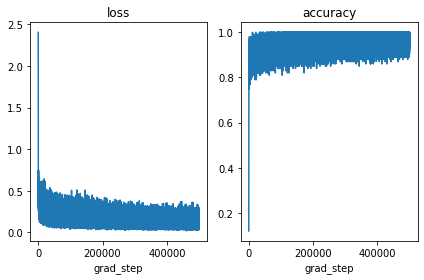

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(loss_trace)
ax2.plot(accuracy_trace)
ax1.set_title('loss')
ax2.set_title('accuracy')
ax1.set_xlabel('grad_step')
ax2.set_xlabel('grad_step')
plt.tight_layout()
plt.show()

In [34]:
print('Test Accuracy :', accuracy_run)

Test Accuracy : 0.9009


In [35]:
from sklearn.metrics import confusion_matrix 
cm = confusion_matrix(y_true=y_test_cls, y_pred=y_test_cls_pred)
print(cm)

[[893   6  22   5   4   2   1   3  45  19]
 [  5 947   2   4   0   3   2   1   4  32]
 [ 15   0 879  29  27  13  25   9   1   2]
 [  4   3  20 804  22 100  26  17   3   1]
 [  2   0  24  33 870  10  24  34   2   1]
 [  4   0  10  76  17 870   4  18   1   0]
 [  3   0  22  16  18   5 933   1   2   0]
 [  3   0   9  12  21  27   2 922   1   3]
 [ 32   6   1   3   1   2   1   0 946   8]
 [  6  31   2   1   0   1   1   1  12 945]]


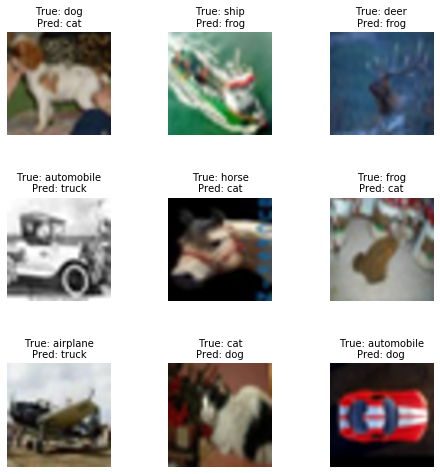

In [60]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, axes = plt.subplots(3, 3, figsize=(8,8))
fig.subplots_adjust(hspace=0.6, wspace=0.3)
idx = 0
for ax in axes.reshape((-1,)):
    while True:
        if y_test_cls[idx]==y_test_cls_pred[idx]:
            idx += 1
        else:
            ax.imshow(x_test[idx].reshape((32,32,3)) / 255., interpolation='spline16')
            true_label = cls_names[y_test_cls[idx]]
            pred_label = cls_names[y_test_cls_pred[idx]]
            ax.set_title('True: {}\nPred: {}'.format(true_label, pred_label), fontsize=10)
            ax.axis('off')
            idx += 1
            break
plt.show()